# 05.05 gaussian quadrature

##### code, support for section text

In [ ]:
if True: # settings for the people
  import matplotlib.pyplot as plt
  import numpy as np
  import scipy as sp
  import sympy as sy
  from tabulate import tabulate

###### code, legendre

In [ ]:
def legendre(n,x):
  if n == 0:
    return np.ones_like(x)
  elif n == 1:
    return x
  else:
    return ((2*n-1)*x*legendre(n-1,x) - (n-1)*legendre(n-2,x)) /n


In [ ]:
def legendre_dp(n, x):
  return n*(x*legendre(n,x) - legendre(n-1,x)) /(x**2 - 1)

In [ ]:
def legendre_roots(n, max_iterations=100,tolerance=1e-15):
  roots = np.cos(np.pi*(4*np.arange(1,n+1)-1)/(4*n+2)) # initial guess

  for _ in range(max_iterations):
    p = legendre(n,roots)
    p_prime = legendre_dp(n,roots)

    new_roots = roots - p / p_prime
    if np.all(np.abs(new_roots - roots) < tolerance):
      roots = new_roots
      break
    roots = new_roots

  weights = 2 / ((1-roots**2)*p_prime**2)
  return roots, weights


###### code, images in order of appearance

In [ ]:
# visual, display n legendre polynomials on [-1,1]

def do_something(n):
  '''
  n: degree of legendre polynomial
  '''

  # data
  xx = (-1,1)
  xs = np.linspace(xx[0],xx[1],101)

  # plot, data
  for i in range(n):
    plt.plot(xs,legendre(i,xs),label=f"$P_{i}$")

  # plot, style
  plt.title("legendre polynomials\n") # ,y=-0.1,pad=-14) # for title below
  plt.legend(bbox_to_anchor=(1.01,1.01),loc='upper left')
  plt.grid()

  # plot, show
  plt.show()


In [ ]:
# visual, display for gaussian quadrature roots and coefficients

def do_something_else():
  data = []
  for i in range(2,5):
    xs,ws = sp.special.roots_legendre(i)
    xs_ih,ws_ih = legendre_roots(i) # in-house
    for x,w,x_ih,w_ih in zip(xs,ws,xs_ih,ws_ih):
      data.append([i,x,x_ih,w,w_ih])

  print("\nscipy.special.roots_legendre(n) & in-house\n")
  print(tabulate(data,headers=["n","roots","in-house","coeffs","in-house"],tablefmt="github"),"\n")


###### code, examples

In [ ]:
# example 15: gaussian guadrature vs some stuff

def ex15(f,xx,n,d):

  # gaussian quadrature, fixed order
  s_gq,meh = sp.integrate.fixed_quad(f,xx[0],xx[1],n=n) # degree 4
  print() # spacer
  print(f"gaussian quadrature {s_gq}")
  print() # spacer

  # romberg, fixed step h
  h = (xx[1]-xx[0])/d
  xs = np.linspace(xx[0],xx[1],d+1)
  sp.integrate.romb(f(xs),dx=h,show=True)

  # benchmark: fortran QUADPACK which uses lots of stuff
  s_gq,meh = sp.integrate.quad(f,xx[0],xx[1]) # ,maxiter=4)
  print() # spacer
  print(f"benchmark {s_gq} with error estimate {meh:.16e}")


## 0 intro

the precision of quadrature is the degree of its polynomial without error. newton-cotes of degree $n$ has precision $n$ (for $n$ odd) and $n+1$ for (for $n$ even). ie, trapezoid is degree 1, precision one and simpsons is degree 2, precise up to and including third degree polynomials.

newton-cotes achieves these precisions for evenly spaced points. so if quadrature does away with "evenly spaced", what other methods might swap out newton-cotes? does this course not swing between newton and gauss, so guess whos back.

given $n+1$ points, gaussian quadrature has precision $2n+1$, double that of newton.

##### <b><font color=grey>definition 03</font> orthogonal functions</b>

the set of nonzero functions ${p_0,\dots,p_n}$ on interval $[a,b]$ is orthogonal on $[a,b]$ if

\begin{align}
  \int_a^b p_j(x)\; p_k(x)\; dx =
  \left\{
    \begin{array}{r l}
      0 & j\ne k \\
      \ne 0 & j=k.
    \end{array}
  \right.
\end{align}

##### <b><font color=grey>theorem 04</font></b>

if $\{p_0, p_1,\dots,p_n\}$ is an orthogonal set of polynomials on the interval $[a,b]$, where degree $p_i = i$, then $\{p_0, p_1,\dots,p_n\}$ is a basis for the vector space of degree at most $n$ polynomials on $[a,b]$.

##### <b><font color=grey>theorem 05</font></b>

if $\{p_0, p_1,\dots,p_n\}$ is an orthogonal set of polynomials on the interval $[a,b]$ and if degree $p_i = i$, then $p_i$ has $i$ distinct roots in the interval $(a,b)$.

##### usw

orthogonality defines and solves least squares problems; <b>gaussian quadrature makes use of orthogonal basis sets</b>.

##### example 13

find a set of three orthogonal polynomials on the interval $[-1,1]$.

easy picks of $p_0(x) = x^0 = 1, p_1(x) = x$ bc

$$\int_{-1}^1\, 1\cdot x\, dx = 0.$$

$p_2(x) = x^2$ lacks orthogonality with $p_0(x)$,

$$\int_{-1}^1 1\cdot x^2\, dx = \frac{2}{3} \ne 0.$$

however, with $p_2(x) = x^2 + c$,

$$\int_{-1}^1 1\cdot (x^2 + c)\, dx = \frac{2}{3} + 2c = 0$$

where $c = -\frac{1}{3}$. ie, set $\{1,x,x^2 - \frac{1}{3}\}$ is an orthogonal set on $[-1,1]$. and those polynomials are also legendre polynomials.

##### example 14: legendre polynomials

show the set of legendre polynomials

$$p_i(x) = \frac{1}{2^ii!}\frac{d^i}{dx^i}[(x^2-1)^i]$$

for $0\le i\le n$ is orthogonal on $[-1,1]$.

note that $p_i(x)$ is degree $i$ polynomial and the $i$th derivative of $(x^2-1)^j$ is divisible by $(x^2-1)$ if $i<j$.

if $i<j$ then

$$\int_{-1}^1 [(x^2-1)^i]^{(i)}[(x^2-1)^j]^{(j)}dx$$

is zero. integrate by parts with $u=[(x^2-1)^i]^{(i)}$ and $dv=[(x^2-1)^j]^{(j)}dx$.

\begin{align}
  uv - \int_{-1}^1 vdu
    &= \left. [(x^2-1)^i]^{(i)}[(x^2-1)^j]^{(j-1)} \right|_{-1}^1
    - \int_{-1}^1 [(x^2-1)^i]^{(i+1)}[(x^2-1)^j]^{(j-1)}dx \\
  \\
  &= - \int_{-1}^1 [(x^2-1)^i]^{(i+1)}[(x^2-1)^j]^{(j-1)}dx
\end{align}

bc $[(x^2-1)^j]^{(j-1)}$ divisible by $(x^2-1)$. after $i+1$ repetions of integration by parts,

$$(-1)^{i+1} \int_{-1}^1 [(x^2-1)^i]^{(2i+1)}[(x^2-1)^j]^{(j-i-1)}dx = 0$$

bc $(2i - 1)^i$ is zero. lol?

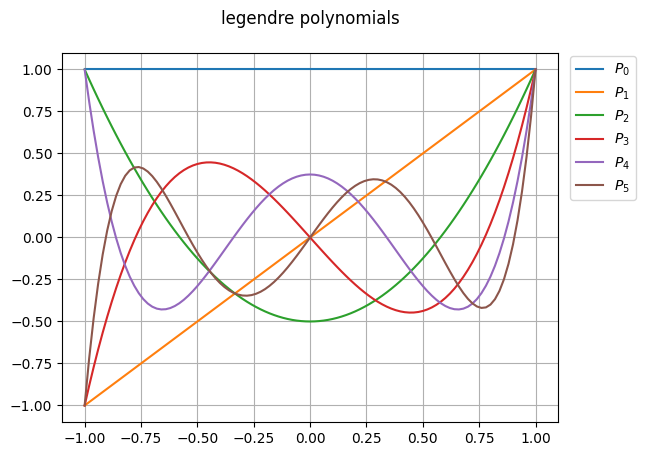

In [ ]:
do_something(6) # n = number of polynomials to show


$n$th legendre polynomial has $n$ roots $x_1,\dots,x_n$ in $[-1,1]$. guassian quadrature of a function is a linear combination of functions evaluated at legendre roots. ie, approximate the integral of the desired function by the intergral of the interpolating polynomial -- whose nodes are legendre roots.

ie, choose $n$ and let $Q(x)$ be the interpolating polynomial for $f(x)$ at nodes $x_1,\dots,x_n$. using lagrange,

$$Q(x) = \sum_{i=1}^n L_i(x)f(x_i), \quad L_i(x) = \frac{(x-x_1)\dots(x-x_i)\dots(x-x_n)}{(x_i-x_1)\dots(x_i-x_i)\dots(x_i-x_n)}.$$

integrating results in the following approximation.

###### <b>gaussian quadrature</b>

$$\int_{-1}^1 f(x)dx \approx \sum_{i=1}^n c_if(x_i), \quad c_i = \int_{-1}^1 L_i(x)dx, i = 1,\dots,n.$$

programmatically,

In [ ]:
do_something_else() # values within reach



scipy.special.roots_legendre(n) & in-house

|   n |     roots |   in-house |   coeffs |   in-house |
|-----|-----------|------------|----------|------------|
|   2 | -0.57735  |   0.57735  | 1        |   1        |
|   2 |  0.57735  |  -0.57735  | 1        |   1        |
|   3 | -0.774597 |   0.774597 | 0.555556 |   0.555556 |
|   3 |  0        |   0        | 0.888889 |   0.888889 |
|   3 |  0.774597 |  -0.774597 | 0.555556 |   0.555556 |
|   4 | -0.861136 |   0.861136 | 0.347855 |   0.347855 |
|   4 | -0.339981 |   0.339981 | 0.652145 |   0.652145 |
|   4 |  0.339981 |  -0.339981 | 0.652145 |   0.652145 |
|   4 |  0.861136 |  -0.861136 | 0.347855 |   0.347855 | 



and fashionably,

$$
\begin{array}{|c|r|r|}
  \hline
  n & \text{roots }x_i \qquad\qquad\qquad\enspace & \text{coefficients } c_i \qquad\qquad \\
  \hline
  2 &
    \begin{array}{r c r}
      -\sqrt{1/3} &= &-0.57735026918963 \\
       \sqrt{1/3} &= & 0.57735026918963
    \end{array}
  &
    \begin{array}{c c r}
      1 &= & 1.00000000000000 \\
      1 &= & 1.00000000000000
    \end{array} \\
  \hline
  3 &
    \begin{array}{r c r}
      -\sqrt{3/5} &= &-0.77459666924148 \\
                0 &= & 0.00000000000000 \\
       \sqrt{3/5} &= & 0.77459666924148
    \end{array}
  &
    \begin{array}{c c r}
      5/9 &= & 0.55555555555555 \\
      8/9 &= & 0.88888888888888 \\
      5/9 &= & 0.55555555555555
    \end{array} \\
  \hline
  4 &
    \begin{array}{r c r}
      -\sqrt{\frac{15+2\sqrt{30}}{35}} &= &-0.86113631159405 \\
      -\sqrt{\frac{15-2\sqrt{30}}{35}} &= &-0.33998104358486 \\
       \sqrt{\frac{15-2\sqrt{30}}{35}} &= & 0.33998104358486 \\
       \sqrt{\frac{15+2\sqrt{30}}{35}} &= & 0.86113631159405 \\
    \end{array}
  &
    \begin{array}{c c r}
      \sqrt{\frac{90-5\sqrt{30}}{180}} &= & 0.34785484513745 \\
      \sqrt{\frac{90+5\sqrt{30}}{180}} &= & 0.65214515486255 \\
      \sqrt{\frac{90+5\sqrt{30}}{180}} &= & 0.65214515486255 \\
      \sqrt{\frac{90-5\sqrt{30}}{180}} &= & 0.34785484513745 \\
    \end{array} \\
  \hline
\end{array}
$$

yes, there are old-fashioned tables for $c_i$!

##### example 15

approximate $\int_{-1}^1 e^{\frac{x^2}{2}}dx$ using gaussian quadrature.

\begin{align}
  n=2 \quad
    &\approx \quad c_1f(x_1) + c_2f(x_2)
    = 1\cdot f(-\sqrt{\frac{1}{3}}) + 1\cdot f(\sqrt{\frac{1}{3}}) \\
  \\
  n=3 \quad
    &\approx \quad c_1f(x_1) + c_2f(x_2) + c_3f(x_3)
    = \frac{5}{9}\cdot f(-\sqrt{\frac{3}{5}})
      + \frac{8}{9}\cdot f(0)
      + \frac{5}{9}\cdot \sqrt{\frac{5}{9}}) \\
  \\
  n=4 \quad
    &\approx \quad c_1f(x_1) + c_2f(x_2) + c_3f(x_3) + c_4f(x_4)
    = \frac{90-5\sqrt{30}}{180}
      \cdot f(-\sqrt{\frac{15+2\sqrt{30}}{35}})
      + \dots
\end{align}

compare code results below for gaussian quadrature (at $n=4$ function evaluations) with romberg fixed step $R_{3,3}$ (which requires 5 function evaluations).

In [ ]:
ex15(lambda x: np.exp(-pow(x,2)/2.),(-1,1),n=4,d=4) # d=4 to get R₃₃



gaussian quadrature 1.7112245045994898

Richardson Extrapolation Table for Romberg Integration
 1.21306 
 1.60653  1.73769 
 1.68576  1.71217  1.71047 

benchmark 1.7112487837842973 with error estimate 1.8998678006191232e-14


##### usw: why do the gaussian quadrature roots work so well?

##### <b><font color=grey>theorem 06</font></b>: guassian quadrature precision

gaussian quadrature using the $n$ degree legendre polynomial on $[-1,1]$ has precision $2n-1$.

###### proof

let $P(x)$ be polynomial of degree at most $2n-1$. show it is integrated exactly by gaussian quadrature.

by long division,

$$P(x) = S(x)p_n(x) + R(x)$$

where $S(x)$ and $R(x)$ are polynomials of degree less than $n$. gaussian quadrature will be exact on $R(x)$ bc it integrates the interpolating polynomial of degree $n-1$, which is identical to $R(x)$.

at the roots $x_i$ of the $n$th legendre polynomial, $P(x_i) = R(x_i)$, since $p_n(x_i) = 0$ for all $i$. this implies their gaussian quadrature approximations will be the same. their integrals are also identical.

$$\int_{-1}^1 P(x)\, dx = \int_{-1}^1 S(x)p_n(x)\, dx + \int_{-1}^1 R(x)\, dx = 0 + \int_{-1}^1 R(x)\, dx$$

by theorem 5.4, $S(x)$ can be written as a linear combination of polynomials of degree less than $n$, which are orthogonal to $p_n(x)$. since gaussian quadrature is exact on $R(x)$, it must also be for $P(x)$. $\blacksquare$

also, to approximate integrals on a general $[a,b]$, translate it back to $[-1,1]$. eg, $t = \frac{(2x-a-b)}{(b-a)}$ such that

$$\int_a^b f(x)\, dx = \int_{-1}^1 f\left( \frac{(b-a)\cdot t + b + a}{2} \right) \frac{b-a}{2}\, dt$$

##### <b><font color=grey>theorem 07</font></b>: guassian quadrature optimality

no $n$-point quadrature rule can have a degree of precision higher than $2n-1$.

###### proof

1. an $n$-point quadrature has $2n$ parameters: $n$ nodes $x_1, \dots, x_n$ and $n$ weights $w_1, \dots, w_n$. ie, $\int f(x)dx \approx \sum w_if(x_i)$.

2. for a quadrature to have degree of precision $k$, it must exactly integrate all polynomials up to degree $k$. ie, $\int x_i dx = \sum w_i x_i^j$ for $j = 0,1,\dots k$. each $j$ gives one equation and $k+1$ are needed for $j=0,1,\dots,k$.

3. each equation $\sum w_i x_i^j dx$ is independent bc moments of monomials are linearly independent.

4. by linear algebra: given $2n$ unknown parameters and $k+1$ equations, then $k+1 \le 2n \Rightarrow k \le 2n-1$. $\checkmark$

## references

* gaussian [@wiki](https://en.wikipedia.org/wiki/Gaussian_quadrature)
* quadrature [@scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quadrature.html)

## resources

meh, youre fine.